In [98]:
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
        print("Setting GPU Memory Growth...")
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

import time
import datetime

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from plot_keras_history import plot_history
import sklearn.metrics as metrics
import os as os

import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.python.client import device_lib

import kerastuner as kt
from kerastuner.tuners import RandomSearch, BayesianOptimization

from tcn import TCN


print("TF version:", tf.__version__)
print("KT version:", kt.__version__)
print("Panda version:", pd.__version__)

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print("Physical devices: ", tf.config.list_physical_devices())
# Se va a habilitar la dedicacion dinamica de memoria para que la GPU vaya asignando recursos al proceso conforme los vaya necesitando

if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
#print(tf.config.list_physical_devices('GPU'))
print("Build with CUDA: ", tf.test.is_built_with_cuda())

# Number of measurements to predict
numPredictions = 20

# Number of best models
numBestModels = 1 

# Validation set percentage
val_size = 0.3

# Batch size
batch = 1024

# Filters parameters
minFilters = 32
maxFilters = 128
stepsFilters = 32
defaultFilters = 32

# Filters parameters
minKernels = 2
maxKernels = 5
stepsKernels = 1
defaultKernels = 3

# Filters parameters
dilations = [1, 2, 4, 8, 16]

# Layers parameters
minLayers = 1
maxLayers = 10
defaultLayers = 3

# Dropout Parameters
minDropout = 0
maxDropout = 0.33
defaultDropout = 0.25

# Establish loss measure
loss = "mean_absolute_error"

# Learning rate
learningRate = [0.0, 1e-2, 1e-3, 1e-4]

# Model metrics
modelMetrics = [keras.metrics.MAE, tf.keras.metrics.RootMeanSquaredError(name = 'rmse')]

# Optimizer objetive: error percetange with the validation set 
objective = kt.Objective('val_mean_absolute_error', 'min')

# Maximum model trials and executions
trials = 2
executions = 5

# Epochs
epchs = 1000

Setting GPU Memory Growth...


c:\Users\hecto\.conda\envs\myenv\lib\site-packages\tensorflow_core\python\client\session.py:1752: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


TF version: 2.1.0
KT version: 1.0.1
Panda version: 1.1.5
Physical devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Default GPU Device: /device:GPU:0
Num GPUs Available:  1
Build with CUDA:  True


In [99]:
df = pd.read_csv("C:/Users/hecto/Documents/Master/TFM/tfm-renewable-energy-deep-learning/data/training/2015_PV_W140_H20.csv",
                delimiter=";")

dfTest = pd.read_csv("C:/Users/hecto/Documents/Master/TFM/tfm-renewable-energy-deep-learning/data/test/2016_PV_W140_H20.csv",
                delimiter=";")

# X = pd.read_csv("C:/Users/hecto/Documents/Master/TFM/tfm-renewable-energy-deep-learning/data/training/2015_Weather_W1.csv",
#                        delimiter=",")

# xTest = pd.read_csv("C:/Users/hecto/Documents/Master/TFM/tfm-renewable-energy-deep-learning/data/test/2016_Weather_W1.csv",
#                    delimiter=",")

# projectNameBO = "Weather_W1-lstm-bo"
# projectNameRS = "Weather_W1-lstm-rs"

projectNameRS = "PV_W140_H20-tcn-rs"
projectNameBO = "PV_W140_H20-tcn-bo"

W=140
H=20

#  Uncomment in order to normalize data
# Data Normalization

df = df.replace(',', '.', regex=True)
dfTest = dfTest.replace(',', '.', regex=True)

scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df))
dfTest = pd.DataFrame(scaler.fit_transform(dfTest))

In [100]:
# Preprocessing for PV_W_H type files:

# Filter for PV data
X = df.iloc[:, 0:W]
xTest = dfTest.iloc[:, 0:W]

Y = df.iloc[:, W:]
yTest = dfTest.iloc[:, W:]

numPredictions = H

print(X)
print(yTest)

          0         1         2         3         4         5         6    \
0    0.202547  0.343202  1.000000  0.842291  0.577134  0.745918  0.996233   
1    0.426514  0.294835  0.574558  0.485647  0.827078  0.838485  0.959061   
2    0.230347  0.267902  0.116575  0.189409  0.229192  0.324692  0.254022   
3    0.815427  0.732371  0.665736  0.544064  0.661029  0.580754  0.651991   
4    0.586870  0.752408  0.486835  0.536889  0.585460  0.500163  0.220289   
..        ...       ...       ...       ...       ...       ...       ...   
353  0.814352  0.884869  0.639417  0.734076  0.927453  0.945354  0.827834   
354  0.751755  0.893851  0.866711  0.999158  0.927207  0.927505  0.958282   
355  0.507537  0.664454  0.640321  0.697187  0.894575  0.850608  0.559587   
356  0.689605  0.568433  0.651532  0.811900  0.694811  0.655561  0.903678   
357  0.512738  0.738997  0.641405  0.495840  0.508740  0.454383  0.320331   

          7         8         9    ...       130       131       132  \
0  

In [101]:
# # Preprocessing for W type files:

# # Filter for PV data
# X = X.iloc[:, ::PV_index]
# xTest = xTest.iloc[:, ::PV_index]

# numPredictions = len(X.columns)

# # Reset column names
# new_column_names = [f'PV_{i+1}' for i in range(numPredictions)]
# X.columns = new_column_names
# xTest.columns = new_column_names

# Y = pd.DataFrame.copy(X)
# yTest = pd.DataFrame.copy(xTest)

# # Create Y from taking next day data
# Y = Y.drop(0)
# Y = Y.reset_index(drop = True)
# Y.loc[len(Y)] = np.zeros(numPredictions)

# yTest = yTest.drop(0)
# yTest = yTest.reset_index(drop = True)
# yTest.loc[len(yTest)] = np.zeros(numPredictions)

# print(X)
# print(yTest)

In [102]:
# # Old Data preprocessing: each row will contain the 20 measures for each day , and the 10 measures for the following day
# # X = pd.DataFrame(np.array(training).reshape(-1, W))
# Y = pd.DataFrame.copy(X)
# yTest = pd.DataFrame.copy(xTest)

# Y.columns = ["col_{}".format(i) for i in range(W+1, (2*W)+1)]
# Y = Y.drop(0)
# Y = Y.reset_index(drop = True)
# Y.loc[len(Y)] = np.zeros(numPredictions)

# # Last row is deleted because it is the one used for the real prediction, 
# # it is not useful for the training of the model. 
# X.drop(X.tail(1).index, inplace = True)
# Y.drop(Y.tail(1).index, inplace = True)

# print("X Preproccessed shape: ", X.shape)
# print("Y Preproccessed shape: ", Y.shape)
# print("---------------------------------------------")

# #  Uncomment in order to normalize data
# # Data Normalization
# # scaler = MinMaxScaler()
# # X = pd.DataFrame(scaler.fit_transform(X), columns=["col_{}".format(i) for i in range(1, 21)])
# # Y = pd.DataFrame(scaler.fit_transform(Y), columns=["col_{}".format(i) for i in range(21, 41)])

In [103]:
# dfPreproccessed = pd.concat([X, Y], axis = 1)

# print("DataFrame Preproccessed:")
# print(dfPreproccessed)
# print("---------------------------------------------")

# # Split the data into training and validation sets
# xTrain, xVal, yTrain, yVal = train_test_split(X, 
#                                             Y, 
#                                             test_size = val_size, 
#                                             random_state = 0, 
#                                             shuffle=False)

# # Show subsets shapes
# print("Shapes:")
# print("xTrain:\t"+str(xTrain.shape))
# print("yTrain:\t"+str(yTrain.shape))
# print("xVal:\t"+str(xVal.shape))
# print("yVal:\t"+str(yVal.shape))
# print("xTest:\t"+str(xTest.shape))
# print("yTest:\t"+str(yTest.shape))
# print("---------------------------------------------")

In [104]:
dfPreproccessed = pd.concat([X, Y], axis = 1)

print("DataFrame Preproccessed:")
print(dfPreproccessed)
print("---------------------------------------------")

# Split the data into training and validation sets
xTrain, xVal, yTrain, yVal = train_test_split(X, 
                                            Y, 
                                            test_size = val_size, 
                                            random_state = 0, 
                                            shuffle=False)

# Adding the third dimension needed to use LSTM (samples, timestamps, features)
xtrain = np.reshape(xTrain.values, (xTrain.shape[0], 1, xTrain.shape[1]))
ytrain = np.reshape(yTrain.values, (yTrain.shape[0], 1, yTrain.shape[1]))
xval = np.reshape(xVal.values, (xVal.shape[0], 1,  xVal.shape[1]))
yval = np.reshape(yVal.values, (yVal.shape[0], 1, yVal.shape[1]))
xtest = np.reshape(xTest.values, (xTest.shape[0], 1, xTest.shape[1]))
ytest = np.reshape(yTest.values, (yTest.shape[0], 1, yTest.shape[1]))

# New shapes after third dimension added
print("Dimensions afther third dimension added:")
print("xTrain:\t"+str(xtrain.shape))
print("yTrain:\t"+str(ytrain.shape))
print("xVal:\t"+str(xval.shape))
print("yVal:\t"+str(yval.shape))
print("xTest:\t"+str(xtest.shape))
print("yTest:\t"+str(ytest.shape))

DataFrame Preproccessed:
          0         1         2         3         4         5         6    \
0    0.202547  0.343202  1.000000  0.842291  0.577134  0.745918  0.996233   
1    0.426514  0.294835  0.574558  0.485647  0.827078  0.838485  0.959061   
2    0.230347  0.267902  0.116575  0.189409  0.229192  0.324692  0.254022   
3    0.815427  0.732371  0.665736  0.544064  0.661029  0.580754  0.651991   
4    0.586870  0.752408  0.486835  0.536889  0.585460  0.500163  0.220289   
..        ...       ...       ...       ...       ...       ...       ...   
353  0.814352  0.884869  0.639417  0.734076  0.927453  0.945354  0.827834   
354  0.751755  0.893851  0.866711  0.999158  0.927207  0.927505  0.958282   
355  0.507537  0.664454  0.640321  0.697187  0.894575  0.850608  0.559587   
356  0.689605  0.568433  0.651532  0.811900  0.694811  0.655561  0.903678   
357  0.512738  0.738997  0.641405  0.495840  0.508740  0.454383  0.320331   

          7         8         9    ...       150  

In [105]:

# Model definition:
with tf.device('/gpu:0'): 
    
    def build_model(hp): 

        model = Sequential()
        
        # First layer: TCN. Number of nb_filters, kernel_size, and dilations optimization.
        model.add(TCN(nb_filters = hp.Int('filters', 
                                    min_value = minFilters,
                                    max_value = maxFilters, 
                                    step = stepsFilters,
                                    default = defaultFilters),
                        kernel_size = hp.Int('kernel_size', 
                                    min_value = minKernels,
                                    max_value = maxKernels, 
                                    step = stepsKernels,
                                    default = defaultKernels),
                        dilations = dilations,
                        return_sequences = True, 
                        input_shape = (xtrain.shape[1], xtrain.shape[2])))

        # Second layer: Dropout with percetange optimization
        model.add(
            Dropout(hp.Float('dropout', 
                            min_value = minDropout,
                            max_value = maxDropout,
                            default = defaultDropout)))
        
        # Last layer:
        model.add(Dense(numPredictions))

        print("Summary: ")
        model.summary()

        # # Set Epsilon to 1, in order to fix huge MAPE values.
        # keras.backend.set_epsilon(1)

        # Model compilation: learning rate optimization
        model.compile(loss = loss,
                    optimizer = keras.optimizers.Adam(hp.Choice('learning_rate', 
                                                                values = learningRate)),
                    metrics = modelMetrics)

        return model

In [106]:
# Model training:
with tf.device('/gpu:0'): 
    # Create optimizer
    tcnOptimizer = RandomSearch(build_model, 
                                objective = objective,
                                max_trials = trials, 
                                executions_per_trial = executions,
                                project_name = projectNameRS,
                                overwrite=True)
    
    # Search space summary
    tcnOptimizer.search_space_summary()

    # Search execution with epochs
    initialTime = time.time()
    tcnOptimizer.search(x = xtrain,
                        y = ytrain, 
                        epochs = epchs,
                        batch_size = batch,
                        validation_data=(xval, yval))
    finalTime = time.time()

    # Results summary
    tcnOptimizer.results_summary()

    # Get best model generated
    model = tcnOptimizer.get_best_models(num_models = numBestModels)[0]

    # Model training with epochs 
    history = model.fit(
                xtrain,
                ytrain,
                epochs = epchs,
                batch_size = batch,
                validation_data=(xval, yval))

    # Show model info
    print("Tiempo de entrenamiento (en segundos):\t"+str(finalTime - initialTime))
    print(history.history.keys())
    print(model.history.history)
    print(model.history.params)

Summary: 
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn (TCN)                    (None, 1, 32)             45920     
_________________________________________________________________
dropout (Dropout)            (None, 1, 32)             0         
_________________________________________________________________
dense (Dense)                (None, 1, 20)             660       
Total params: 46,580
Trainable params: 46,580
Non-trainable params: 0
_________________________________________________________________


Summary: 
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn (TCN)                    (None, 1, 96)             400032    
_________________________________________________________________
dropout (Dropout)            (None, 1, 96)             0         
_________________________________________________________________
dense (Dense)                (None, 1, 20)             1940      
Total params: 401,972
Trainable params: 401,972
Non-trainable params: 0
_________________________________________________________________
Train on 250 samples, validate on 108 samples
Epoch 1/1000
250/250 [==============================] - 2s 9ms/sample - loss: 0.9032 - mean_absolute_error: 0.9032 - rmse: 1.1311 - val_loss: 2.2982 - val_mean_absolute_error: 2.2982 - val_rmse: 2.6632
Epoch 2/1000
250/250 [==============================] - 0s 291us/sample - loss: 1.8046 - mean_absolute_error: 1.8046 - rms

Summary: 
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn (TCN)                    (None, 1, 64)             147136    
_________________________________________________________________
dropout (Dropout)            (None, 1, 64)             0         
_________________________________________________________________
dense (Dense)                (None, 1, 20)             1300      
Total params: 148,436
Trainable params: 148,436
Non-trainable params: 0
_________________________________________________________________
Train on 250 samples, validate on 108 samples
Epoch 1/1000
250/250 [==============================] - 2s 7ms/sample - loss: 1.0232 - mean_absolute_error: 1.0232 - rmse: 1.2244 - val_loss: 1.3623 - val_mean_absolute_error: 1.3623 - val_rmse: 1.5909
Epoch 2/1000
250/250 [==============================] - 0s 90us/sample - loss: 1.0273 - mean_absolute_error: 1.0273 - rmse

INFO:tensorflow:Oracle triggered exit


Summary: 
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn (TCN)                    (None, 1, 96)             400032    
_________________________________________________________________
dropout (Dropout)            (None, 1, 96)             0         
_________________________________________________________________
dense (Dense)                (None, 1, 20)             1940      
Total params: 401,972
Trainable params: 401,972
Non-trainable params: 0
_________________________________________________________________
Train on 250 samples, validate on 108 samples
Epoch 1/1000
250/250 [==============================] - 1s 5ms/sample - loss: 0.1385 - mean_absolute_error: 0.1385 - rmse: 0.1821 - val_loss: 0.2170 - val_mean_absolute_error: 0.2170 - val_rmse: 0.2599
Epoch 2/1000
250/250 [==============================] - 0s 123us/sample - loss: 0.1386 - mean_absolute_error: 0.1386 - rms

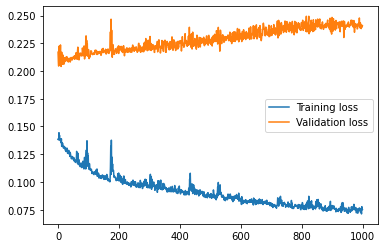

359/359 [==============================] - ETA: 0s - loss: 0.2512 - mean_absolute_error: 0.2512 - rmse: 0.31 - 0s 538us/sample - loss: 0.1775 - mean_absolute_error: 0.1775 - rmse: 0.2418
Score: [0.17745008919398433, 0.17745009, 0.24177097]


In [107]:
# Training and Validation loss curves
plt.plot(history.history['loss'], label = 'Training loss')
plt.plot(history.history['val_loss'], label = 'Validation loss')
plt.legend()
plt.show()

# Model evaluation with validation data
score = model.evaluate(xtest, ytest)
print('Score:', score)

In [108]:
# Model training:
with tf.device('/gpu:0'): 
    # Create optimizer
    tcnOptimizer = BayesianOptimization(build_model, 
                                objective = objective,
                                max_trials = trials, 
                                executions_per_trial = executions,
                                project_name = projectNameBO,
                                overwrite=True)
    
    # Search space summary
    tcnOptimizer.search_space_summary()

    # Search execution with epochs
    initialTime = time.time()
    tcnOptimizer.search(x = xtrain,
                        y = ytrain, 
                        epochs = epchs,
                        batch_size = batch,
                        validation_data=(xval, yval))
    finalTime = time.time()

    # Results summary
    tcnOptimizer.results_summary()

    # Get best model generated
    model = tcnOptimizer.get_best_models(num_models = numBestModels)[0]

    # Model training with epochs 
    history = model.fit(
                xtrain,
                ytrain,
                epochs = epchs,
                batch_size = batch,
                validation_data=(xval, yval))

    # Show model info
    print("Tiempo de entrenamiento (en segundos):\t"+str(finalTime - initialTime))
    print(history.history.keys())
    print(model.history.history)
    print(model.history.params)

Summary: 
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn (TCN)                    (None, 1, 32)             45920     
_________________________________________________________________
dropout (Dropout)            (None, 1, 32)             0         
_________________________________________________________________
dense (Dense)                (None, 1, 20)             660       
Total params: 46,580
Trainable params: 46,580
Non-trainable params: 0
_________________________________________________________________


Summary: 
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn (TCN)                    (None, 1, 32)             59616     
_________________________________________________________________
dropout (Dropout)            (None, 1, 32)             0         
_________________________________________________________________
dense (Dense)                (None, 1, 20)             660       
Total params: 60,276
Trainable params: 60,276
Non-trainable params: 0
_________________________________________________________________
Train on 250 samples, validate on 108 samples
Epoch 1/1000
250/250 [==============================] - 2s 8ms/sample - loss: 0.5552 - mean_absolute_error: 0.5552 - rmse: 0.7062 - val_loss: 0.5739 - val_mean_absolute_error: 0.5739 - val_rmse: 0.6917
Epoch 2/1000
250/250 [==============================] - 0s 247us/sample - loss: 0.4299 - mean_absolute_error: 0.4299 - rmse:

Summary: 
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn (TCN)                    (None, 1, 96)             400032    
_________________________________________________________________
dropout (Dropout)            (None, 1, 96)             0         
_________________________________________________________________
dense (Dense)                (None, 1, 20)             1940      
Total params: 401,972
Trainable params: 401,972
Non-trainable params: 0
_________________________________________________________________
Train on 250 samples, validate on 108 samples
Epoch 1/1000
250/250 [==============================] - 2s 6ms/sample - loss: 0.8221 - mean_absolute_error: 0.8221 - rmse: 1.0151 - val_loss: 2.7540 - val_mean_absolute_error: 2.7540 - val_rmse: 3.1163
Epoch 2/1000
250/250 [==============================] - 0s 359us/sample - loss: 2.0302 - mean_absolute_error: 2.0302 - rms

INFO:tensorflow:Oracle triggered exit


Summary: 
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn (TCN)                    (None, 1, 96)             400032    
_________________________________________________________________
dropout (Dropout)            (None, 1, 96)             0         
_________________________________________________________________
dense (Dense)                (None, 1, 20)             1940      
Total params: 401,972
Trainable params: 401,972
Non-trainable params: 0
_________________________________________________________________
Train on 250 samples, validate on 108 samples
Epoch 1/1000
250/250 [==============================] - 1s 5ms/sample - loss: 0.1256 - mean_absolute_error: 0.1256 - rmse: 0.1678 - val_loss: 0.2094 - val_mean_absolute_error: 0.2094 - val_rmse: 0.2780
Epoch 2/1000
250/250 [==============================] - 0s 179us/sample - loss: 0.1321 - mean_absolute_error: 0.1321 - rms

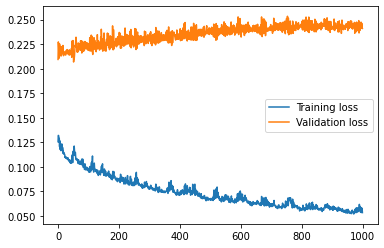

359/359 [==============================] - ETA: 0s - loss: 0.2357 - mean_absolute_error: 0.2357 - rmse: 0.29 - 0s 140us/sample - loss: 0.1827 - mean_absolute_error: 0.1827 - rmse: 0.2439
Score: [0.18273365472684663, 0.18273364, 0.24386168]


In [109]:
# Training and Validation loss curves
plt.plot(history.history['loss'], label = 'Training loss')
plt.plot(history.history['val_loss'], label = 'Validation loss')
plt.legend()
plt.show()

# Model evaluation with validation data
score = model.evaluate(xtest, ytest)
print('Score:', score)